In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


#Libraries for processing images

!cp /kaggle/input/gdcm-conda-install/gdcm.tar .
!tar -xvzf gdcm.tar
!conda install --offline ./gdcm/gdcm-2.8.9-py37h71b2a6d_0.tar.bz2
#!rm -rf ./gdcm.tar


!pip install pylibjpeg
!pip install pylibjpeg-openjpeg
!pip install pylibjpeg-libjpeg
!pip install pillow
!pip install pydicom

# !pip install --no-cache-dir -I pylibjpeg
# !pip install --no-cache-dir -I pylibjpeg-openjpeg
# !pip install --no-cache-dir -I pylibjpeg-libjpeg
# !pip install --no-cache-dir -I pillow
# !pip install --no-cache-dir -I pydicom

import pydicom
    

    
    
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

gdcm/
gdcm/conda-4.8.4-py37hc8dfbb8_2.tar.bz2
gdcm/gdcm-2.8.9-py37h71b2a6d_0.tar.bz2
gdcm/libjpeg-turbo-2.0.3-h516909a_1.tar.bz2

######################################################################## | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 2.5 MB/s eta 0:00:0000:01:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 32.8 MB/s eta 0:00:0000:0100:01


In [2]:
#Get info of train files in the directory

BASE_DIR = '/kaggle/input/rsna-breast-cancer-detection/'
train_dir = BASE_DIR+"train.csv"
train_df = pd.read_csv(train_dir)
train_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [3]:
#Create path for each image

train_df['img_path'] = pd.Series([BASE_DIR+'train_images/']*len(train_df)) + train_df['patient_id'].astype(str) + pd.Series(['/']*len(train_df)) + train_df['image_id'].astype(str) + pd.Series(['.dcm']*len(train_df))
train_df

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,img_path
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,/kaggle/input/rsna-breast-cancer-detection/tra...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54701,1,9973,1729524723,R,MLO,43.0,0,0,0,1.0,0,C,49,False,/kaggle/input/rsna-breast-cancer-detection/tra...
54702,1,9989,63473691,L,MLO,60.0,0,0,0,NaN,0,C,216,False,/kaggle/input/rsna-breast-cancer-detection/tra...
54703,1,9989,1078943060,L,CC,60.0,0,0,0,NaN,0,C,216,False,/kaggle/input/rsna-breast-cancer-detection/tra...
54704,1,9989,398038886,R,MLO,60.0,0,0,0,0.0,0,C,216,True,/kaggle/input/rsna-breast-cancer-detection/tra...


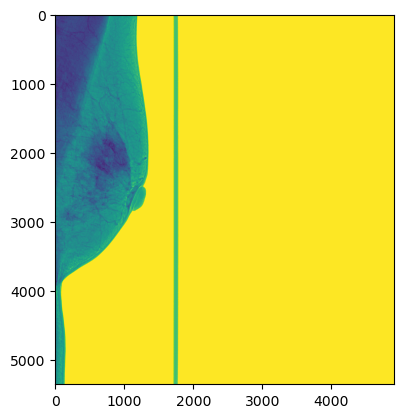

In [4]:
#View Sample Image

dcm = pydicom.dcmread(train_df.loc[1,'img_path'])

# Get the pixel data as a NumPy array
pixel_data = dcm.pixel_array.astype(float)

# Show image
plt.imshow(pixel_data)

In [5]:
#Sample dataset

train_sample = []

x_ = train_df.values.copy()
y_ = train_df['cancer'].values

for i in np.unique(y_):
    x = x_[y_ == i]
    
    indices = np.random.randint(low = 0,high = len(x), size = 10)
    
    x = x[indices]
    
    train_sample.extend(x)
    
train_sample = pd.DataFrame(np.array(train_sample))

del x_, y_, x

train_sample.columns = train_df.columns

In [6]:
# Load the DICOM file

def img_to_pixels(img):
    
    dcm = pydicom.dcmread(img)
    
    # Get the pixel data as a NumPy array
    pixel_data = dcm.pixel_array.astype(float).flatten()
    
    return pixel_data

In [7]:
train_sample['img_pixels'] = train_sample['img_path'].apply(img_to_pixels)
train_sample

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,img_path,img_pixels
0,2,57943,1433315355,L,MLO,61.0,0,0,0,NaN,0,NaN,21,False,/kaggle/input/rsna-breast-cancer-detection/tra...,"[1838.0, 1793.0, 1686.0, 1739.0, 1456.0, 1414...."
1,1,6348,639085425,L,MLO,68.0,0,0,0,0.0,0,B,49,True,/kaggle/input/rsna-breast-cancer-detection/tra...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2,44162,1106316106,L,CC,66.0,0,0,0,NaN,0,NaN,48,False,/kaggle/input/rsna-breast-cancer-detection/tra...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1,46707,765827894,L,MLO,48.0,0,0,0,NaN,0,C,49,False,/kaggle/input/rsna-breast-cancer-detection/tra...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,2,14584,1365200573,L,CC,55.0,0,0,0,NaN,0,NaN,21,False,/kaggle/input/rsna-breast-cancer-detection/tra...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,2,11685,1143038723,R,MLO,48.0,0,0,0,0.0,0,NaN,29,True,/kaggle/input/rsna-breast-cancer-detection/tra...,"[3492.0, 3492.0, 3492.0, 3492.0, 3492.0, 3492...."
6,2,37949,378111330,R,MLO,62.0,0,0,0,NaN,0,NaN,21,False,/kaggle/input/rsna-breast-cancer-detection/tra...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,1,60425,690612382,R,CC,67.0,0,1,0,0.0,0,B,49,True,/kaggle/input/rsna-breast-cancer-detection/tra...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,2,49512,1787699975,L,CC,59.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...,"[3940.0, 3940.0, 3940.0, 3940.0, 3940.0, 3940...."
9,2,49725,1728469032,R,MLO,62.0,0,0,0,0.0,0,NaN,48,True,/kaggle/input/rsna-breast-cancer-detection/tra...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [14]:
#Check number of pixels of a random image

img_to_pixels(train_df.loc[0,'img_path']).shape

(26319825,)